In [0]:
# [연습]_colab_bert_finetuning.ipynb
# 200102(목) 12:17~
# 천성욱

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mxnet-cu101
!pip install gluonnlp pandas tqdm
!pip install sentencepiece==0.1.85
!pip install transformers==2.1.1
!pip install torch==1.3.1

     |████████████████████████████████| 551.3MB 26kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 245kB 45.2MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.8.2-cp36-none-any.whl size=293515 sha256=516a6a44d5a0d4181d52efc973aa151e545178440c5501995ac09408bcb84caf
  Stored in directory: /root/.cache/pip/wheels/a4/aa/61/0aebc5c078c4b1ccf325cd7579932b99403008da6e7ce6b68f
Successfully built gluonnlp
     |████████████████████████████████| 317kB 13.0MB/s 
  Found existing installation: transformers 2.2.0
    Uninstalling transformers-2.2.0:
      Successfully uninstalled transformers-2.2.0


In [0]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
# from transformers import WarmupLinearSchedule as get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [0]:
tor_odic_weights = torch.load('/content/drive/My Drive/금융문자/모델링/model_KorBERT(ETRI)/1_bert_download_001_bert_morp_pytorch/001_bert_morp_pytorch/pytorch_model.bin')
dic_weights = dict(tor_odic_weights)

In [4]:
d_weight_new = dict()
int_lcnt_f = len(list(dic_weights.items())) -8    # BERT 모델 부분만 로드하기 위해서 8을 빼야한다.
for idx, (k, v) in enumerate(dic_weights.items()):
    if idx ==  int_lcnt_f:
        break
    print(k[5:])
    d_weight_new[k[5:]] = v

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [5]:
from collections import OrderedDict
odic_weight_new = OrderedDict(d_weight_new)
print(list(tor_odic_weights.items())[0][1].shape)
print(list(tor_odic_weights.items())[0])

torch.Size([30349, 768])
('bert.embeddings.word_embeddings.weight', tensor([[-0.0276,  0.0102, -0.0276,  ...,  0.0029, -0.0093, -0.0042],
        [-0.0470,  0.0217, -0.0154,  ..., -0.0391,  0.0253,  0.0215],
        [-0.0147, -0.0300, -0.0310,  ..., -0.0107, -0.0058,  0.0222],
        ...,
        [-0.0589, -0.0076,  0.0200,  ...,  0.0097, -0.0124,  0.0145],
        [-0.0356, -0.0602, -0.0140,  ...,  0.0230, -0.0017, -0.0488],
        [-0.0531, -0.0201, -0.0196,  ..., -0.0237, -0.0130, -0.0030]]))


In [6]:
from transformers import BertModel
from transformers import BertConfig
model_bert = BertModel(BertConfig(vocab_size_or_config_json_file=30349))
model_bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30349, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [7]:
!nvidia-smi

Sat Jan  4 11:28:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
from transformers import BertForSequenceClassification
# 분류를 위한 BERT 모델 생성
# GPU Mem 누적 1055Mb 차지
# colab 1447Mb 차지
import time
time_i = time.time()
model_sc = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model_sc.cuda()
print(time.time() - time_i)
#1055Mb


100%|██████████| 714314041/714314041 [01:09<00:00, 10294540.34B/s]


83.29525232315063


In [24]:
torch.save(model_sc, 

AttributeError: ignored

In [23]:
model_sc_01 = BertForSequenceClassification
model_sc_01.set_input_embeddings(model_bert, )

TypeError: ignored

In [0]:
dir(BertForSequenceClassification)

In [0]:
dir(model_sc)

In [0]:
model_sc

In [0]:
display(list(dic_weights.keys()))

In [32]:
print(dic_weights['cls.predictions.bias'].shape)
print(dic_weights['cls.predictions.transform.dense.weight'].shape)
print(dic_weights['cls.predictions.transform.dense.bias'].shape)
print(dic_weights['cls.predictions.transform.LayerNorm.weight'].shape)
print(dic_weights['cls.predictions.transform.LayerNorm.bias'].shape)
print(dic_weights['cls.predictions.decoder.weight'].shape)
print(dic_weights['cls.seq_relationship.weight'].shape)
print(dic_weights['cls.seq_relationship.bias'].shape)

torch.Size([30349])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([30349, 768])
torch.Size([2, 768])
torch.Size([2])


In [0]:
model_sc

In [14]:
model_sc.load_state_dict(dic_weights)#{'hi':0})#dic_weights)

RuntimeError: ignored

In [47]:
import time
time_i = time.time()
model_bert.load_state_dict(odic_weight_new)
print(time.time() - time_i)

0.2991673946380615


# classifier 레이어 합치기(진행중)

In [0]:
import torch.nn as nn
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# class BERTClassifier(nn.Module):

In [0]:
import torch.nn as nn
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, token_type_ids, attention_masks, labels):
        
        _, pooler = self.bert(input_ids = token_ids, 
                              token_type_ids = token_type_ids, 
                              attention_mask = attention_masks.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        loss = nn.CrossEntropyLoss(out, labels)
        return loss, self.classifier(out)

In [0]:
device = torch.device("cuda:0")

In [0]:
model = BERTClassifier(model_bert,  dr_rate=0.1).to(device)

In [13]:
!nvidia-smi    # 1183MiB 차지    
# 200104(토) 17:51 1003Mb 차지/ Tesla P4

Sat Jan  4 09:09:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    23W /  75W |   1003MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 데이터 로드 및 전처리

In [50]:
# 판다스로 훈련셋과 테스트셋 데이터 로드
import pandas as pd
path_base = '/content/drive/My Drive/금융문자/데이터/'
# train = pd.read_csv(path_base + "sam60K_lvDist_0_82222_1_whole.csv", encoding='utf-8')
train = pd.read_csv(path_base + "sam32K_lvDist_0_85_1_2.csv", encoding='utf-8')    # 200104(토) 17:51
print(train.shape)
train.head()

(32134, 7)


id year_month  ... len    lvDist
0  303496    2018-09  ...   0  1.000000
1  147557    2017-08  ...   1  1.000000
2  257777    2018-04  ...  31  0.967742
3   84368    2017-05  ...  34  0.947368
4   81268    2017-05  ...  17  0.911765

[5 rows x 7 columns]

In [51]:
import re
re_pat_space = re.compile('\s{2,}')
re_pat_space.sub('g', '안녕  하세       요')
re_pat_words = re.compile('[^가-힣a-zA-Z0-9\s]')
re_pat_words.findall("녕  하세       요")
re_pat_XX_XXX = re.compile('X{2,}')
print(re_pat_XX_XXX.findall('XX고객님 XXX은행입니다. 안녕  하세       요X'))
re_pat_XX_XXX.sub('', 'XX고객님 XXX은행입니다. 안녕  하세       요X')

['XX', 'XXX']


'고객님 은행입니다. 안녕  하세       요X'

In [16]:
train['text'] = train['text'].apply(lambda x: re_pat_XX_XXX.sub(' ', re_pat_space.sub(' ', re_pat_words.sub('', x))))
train#['text']

id year_month  ...  len    lvDist
0      303496    2018-09  ...    0  1.000000
1      147557    2017-08  ...    1  1.000000
2      257777    2018-04  ...   31  0.967742
3       84368    2017-05  ...   34  0.947368
4       81268    2017-05  ...   17  0.911765
...       ...        ...  ...  ...       ...
32129  293353    2018-08  ...  316  0.946203
32130  284216    2018-07  ...  493  0.949290
32131  287940    2018-07  ...  480  0.975000
32132  287290    2018-07  ...  591  0.776650
32133  303566    2018-09  ...  640  0.934375

[32134 rows x 7 columns]

0    1
1    1
2    0
3    0
4    0
Name: smishing, dtype: int64
ratio of smishing: 0.06693844526047177


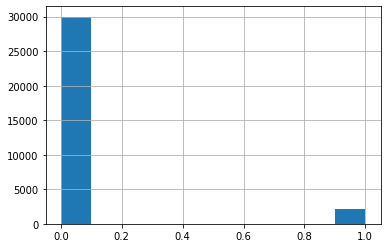

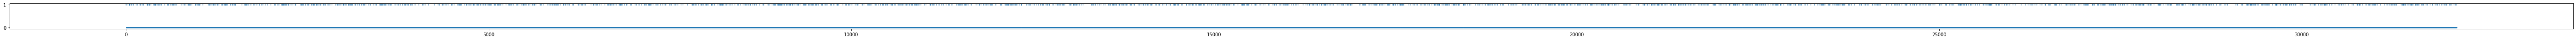

In [17]:
import matplotlib.pyplot as plt
train_rand = train.sample(frac=1, random_state=2020).reset_index()
print(train_rand['smishing'].head())
print('ratio of smishing:', train['smishing'].sum()/len(train['smishing']))
train['smishing'].hist()
plt.figure(figsize=(100,1))
plt.scatter(train_rand['smishing'].index.values, train_rand['smishing'].values, s=1)
plt.show()

In [18]:
# 리뷰 문장 추출
sentences = train_rand['text']
print(sentences[:3])
print(len(sentences))

0    mms 발송광고 안녕하세요   여신영업부입니다장문의 문자를 드려 정말 죄송합니다그럼...
1    국민의 평생 금융파트너   입니다 광고     안녕하세요   영업부입니다 바쁘신 와...
2                      신년달력 고객님1226일브아피룸에서만교부합니다 은행응암 
Name: text, dtype: object
32134


In [19]:
import re
def f_re_pat(x):
#     print('before :', x)
    re_pat_ending = re.compile('(니다)|(세요)|(시오)')
    idx = 0
    for i in range(10):
#         print(idx, x[idx:])
        tmp_search = re_pat_ending.search(x[idx:])
        if tmp_search!=None:
            idx = tmp_search.end() +idx
            x = x[:idx] + ' [SEP]' + x[idx:]
#             print('after  :', x)
            idx += 6    # len(' [SEP]')
        else:
#             print('None')
            break
    if x[-6:] != ' [SEP]':    # 마지막 문장을 if문으로 판단하여, [SEP]를 넣어준다.
        x = x + ' [SEP]'
    return x
f_re_pat(train['text'][2])
# f_re_pat('안녕하세요. 입니다.')

' 0415 1422 카드스마트 710000잔액4869889 [SEP]'

In [20]:
import time
time_i = time.time()
sentences = sentences.apply(f_re_pat).values
print(sentences[:5])
print(time.time() - time_i)

['mms 발송광고 안녕하세요 [SEP]   여신영업부입니다 [SEP]장문의 문자를 드려 정말 죄송합니다 [SEP]그럼에도 문자를 보내드리는것은한국자산관리공사 정부기관 자금지원으로 실행되는 국민행복 마이너스통장대출 안내차 연락 드렸습니다 [SEP] 상품 개요 마이너스 통장 형태의 저신용자 및 고금리 사용자 대출전환 지원 상품 대출한도 500만원 8000만원 까지 개인별 신용및 직급에따라 차이 있음 이율 최저 25 최고 85 자격 조건 사업자 사업자 등록증 소지자로써정상적인 사업 활동자급여소득자 3개월 이상 급여소득 확인자주부 고금리 사용자 및 신규 대출 신청자무직자 고금리 사용자 및 신규 대출 신청자 담당자와 별도의 상담 진행 절차 담당자 배정 및 접수 대출 한도 이율 산정 및 승인 신청자 거래지점 파악 및 진행 지점 배정 신청자 배정 지점으로 승인서 발송 신청자 서류 지참후 지점 방문 접수 및최종 대출금 수령 담당자는 상담 및 심사만 도움드리며 최종   고객님께서 직접 가까운 지점을 방문하셔야대출금 대출카드 수령이 가능하십니다 [SEP] 상담 가능 시간 오전 900오후 1800전국은행연합회등록번호 0406002 담당자 강  대리카카오톡  KANG83대표번호   장문의 내용을 읽어 주셔서 감사합니다 [SEP]언제든지 연락 주신  고객님을 위한최고의 서비스를 약속 드리겠습니다 [SEP] 무료거부  mms 발송 [SEP]'
 '국민의 평생 금융파트너   입니다 [SEP] 광고     안녕하세요 [SEP]   영업부입니다 [SEP] 바쁘신 와중에 각종 홍보전화와 문자를 받으셨을텐데 우선 장문의 문자를 드려 정말 죄송합니다 [SEP] 그럼에도 문자를 보내드리는것은 한국자산관리공사 정부기관 자금지원으로 실행되는  국민행복 마이너스통장으로대출 안내차 연락 드렸습니다 [SEP] 상품 개요 마이너스 통장 형태의 저신용자 및 고금리 사용자 대출 전환 지원 상품 대출한도 500만원 8000만원 까지 대출 한도는 개인신용등급에 따라 차등적용 됩니다 [SEP] 이율 최저 25 최고

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

100%|██████████| 995526/995526 [00:01<00:00, 779572.69B/s]


In [22]:
import time
time_i = time.time()
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])
print(time.time() - time_i)

mms 발송광고 안녕하세요 [SEP]   여신영업부입니다 [SEP]장문의 문자를 드려 정말 죄송합니다 [SEP]그럼에도 문자를 보내드리는것은한국자산관리공사 정부기관 자금지원으로 실행되는 국민행복 마이너스통장대출 안내차 연락 드렸습니다 [SEP] 상품 개요 마이너스 통장 형태의 저신용자 및 고금리 사용자 대출전환 지원 상품 대출한도 500만원 8000만원 까지 개인별 신용및 직급에따라 차이 있음 이율 최저 25 최고 85 자격 조건 사업자 사업자 등록증 소지자로써정상적인 사업 활동자급여소득자 3개월 이상 급여소득 확인자주부 고금리 사용자 및 신규 대출 신청자무직자 고금리 사용자 및 신규 대출 신청자 담당자와 별도의 상담 진행 절차 담당자 배정 및 접수 대출 한도 이율 산정 및 승인 신청자 거래지점 파악 및 진행 지점 배정 신청자 배정 지점으로 승인서 발송 신청자 서류 지참후 지점 방문 접수 및최종 대출금 수령 담당자는 상담 및 심사만 도움드리며 최종   고객님께서 직접 가까운 지점을 방문하셔야대출금 대출카드 수령이 가능하십니다 [SEP] 상담 가능 시간 오전 900오후 1800전국은행연합회등록번호 0406002 담당자 강  대리카카오톡  KANG83대표번호   장문의 내용을 읽어 주셔서 감사합니다 [SEP]언제든지 연락 주신  고객님을 위한최고의 서비스를 약속 드리겠습니다 [SEP] 무료거부  mms 발송 [SEP]
['mm', '##s', '발', '##송', '##광', '##고', '안', '##녕', '##하', '##세', '##요', '[SEP]', '여', '##신', '##영', '##업', '##부', '##입', '##니다', '[SEP]', '장', '##문', '##의', '문', '##자를', '드', '##려', '정', '##말', '죄', '##송', '##합', '##니다', '[SEP]', '그', '##럼', '##에도', '문', '##자를', '보', '##내', '##드', '##리는', '##것', '##은', '##한'

In [89]:
# 라벨 추출
labels = train_rand['smishing'].values
print(labels)

[1 1 0 ... 0 0 0]


## token2id, padding, attention masking

In [90]:
import time
time_i = time.time()
# 입력 토큰의 최대 시퀀스 길이

MAX_LEN = 512#192#128#512#128#512#191227(금)_01   #128191226(목)

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(time.time() - time_i)
input_ids[0]

3.665862560272217


array([ 10366,  10107,   9323, 119057, 118649,  11664,   9521, 118741,
        35506,  24982,  48549,    102,   9565,  25387,  30858,  26784,
        14646,  58303,  48345,    102,   9657,  25934,  10459,   9297,
        48959,   9113,  26737,   9670,  89523,   9687, 119057,  33188,
        48345,    102,   8924, 118866,  35979,   9297,  48959,   9356,
        31605,  15001,  26344, 118627,  10892,  11102,  20479,  13764,
        21386,  20595,  12692,  28000,  12945,   9670,  14646,  12310,
        20595,   9651,  40032,  12508,  78686,   9489,  25549,  24683,
         8909,  36553,  25549,  70915,   9246,  10739,  70162,  12605,
        43022,  13890,  14423,  52363,   9521,  31605,  23466,   9568,
       107693,   9113, 118881, 119081,  48345,    102,   9414,  52951,
         8857,  48549,   9246,  10739,  70162,  12605,   9879,  13890,
         9983,  83616,  10459,   9663,  25387,  24974,  13764,   9316,
         8888,  40032,  12692,   9405,  24974,  13764,   9069,  52363,
      

In [91]:
import time
time_i = time.time()
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(len(attention_masks[0]))
print(attention_masks[0])
print(time.time() - time_i)

512
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [92]:
# 훈련셋과 검증셋으로 분리
nb_samples = 32*4
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids[:nb_samples],
                                                                                    labels[:nb_samples], 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks[:nb_samples], 
                                                       input_ids[:nb_samples],
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([  9414,  43962,  96279,  40032,  86080,   9521,  31605,   9632,  25549,
          9736,  14279,  12508,  34907,   9899,  13890,   9645,  48345,    102,
          9651,  50814,   9414,  43962,  96279,  40032,   9706,  37568,   9751,
         17196,  23466,   9414,  43962,  12030,  14646,   8935,  14040, 118639,
         10739,  39245,  18392,   9580,  31531,  10530,   8996,  34907,  13374,
          9358,  12030,   9706,  37712,  24747,  10892,   9460,  44220,  53529,
          8982, 118920,  12508,   9706,  37712,  24747,  10892,   9946,  14871,
         43962,  12030,  82875,  11261,   9576,  18622,  41693,  58303,  48345,
           102,   9678,  43962,  11102,   9485,  18392,  31605,  10530,   9425,
         46520,   9706, 119251,  13374,   9460,  44220,   9318, 118853,  48345,
           102,  73142,   9554,  32537,  14423,  29935,  40032,  11664,  11018,
          9414,  43962,  12030,   9665,  73295,   8996,  34907,  35506,  14040,
         14867,   9744,  44130,  74986, 

In [105]:
print(train_inputs[0].shape)
print(train_labels[0].shape)
print('len:', len(train_labels[0].shape))
print(train_masks[0].shape)
print(validation_inputs[0].shape)
print(validation_labels[0].shape)
print('len:', len(validation_labels[0].shape))
print(validation_masks[0].shape)

torch.Size([512])
torch.Size([])
len: 0
torch.Size([512])
torch.Size([512])
torch.Size([])
len: 0
torch.Size([512])


In [44]:
# 배치 사이즈
batch_size = 12#32#8#16#32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

NameError: ignored

# 모델 생성 및 하이퍼파라미터 설정

In [0]:
## Setting parameters
max_len = 512#128
batch_size = 12#32
warmup_ratio = 0
num_epochs = 4
max_grad_norm = 1
log_interval = 10
learning_rate =  2e-5

In [0]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8) # eps 0으로 나누는 것을 방지하기 위한 epsilon 값
loss_fn = nn.CrossEntropyLoss()
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
# scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps=warmup_step, t_total=t_total) 원래이거였는데 바꿔줌
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc    

## 훈련 코드

In [0]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [40]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [41]:
print(train_dataloader.batch_size)
print(train_dataloader.dataset.tensors[2][-2].shape)
print(len(train_dataloader.dataset.tensors))

NameError: ignored

In [42]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

NameError: ignored

In [0]:
path_base = '/content/drive/My Drive/금융문자/모델링/models_from_hugging face/'

In [43]:
# torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0
    #@ trainset 정확도 초기화
    train_accuracy = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # Forward 수행                
        outputs = model(b_input_ids, 
                        None,  # token_type_ids=
                        b_input_mask,  # attention_mask=
                        b_labels) # labels=
        # 경과 정보 표시
#         if step % 10 == 0 and not step == 0:
        nb_acc_calc = 0
        if step in [10, 400, 800]:
            model.eval()
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            # 출력 로짓과 라벨을 비교하여 정확도 계산
            time_acc = time.time()
            tmp_train_accuracy = flat_accuracy(outputs[1].detach().cpu().numpy(), b_labels.detach().cpu().numpy())
            train_accuracy += tmp_train_accuracy
            nb_acc_calc += 1
            print(' Train acc : ', tmp_train_accuracy/nb_acc_calc)
            print(format_time(time.time() - time_acc))

        model.train()
        # 로스 구함
        loss = outputs[0]
        # 총 로스 계산
        total_loss += loss.item()
        # Backward 수행으로 그래디언트 계산
        loss.backward()
        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()
        # 스케줄러로 학습률 감소
        scheduler.step()
        # 그래디언트 초기화
        model.zero_grad()
#         torch.save(model, 'weight_191228_samples30000_maxlen128_batchsize32')# + str(epoch_i) + '_' + str(step))
    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()
    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            None, # token_type_ids=
                            b_input_mask) # attention_mask=
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    #@ 모델 저장
    torch.save(model, path_base + 'weight_200102_samp32K(smsh2k)repSEP_X512_bs16' + str(epoch_i) + '_' + str(step))
    print('model weight has been saved.')
    
print("")
print("Training complete!")
# 200102(목) ?23:35~ 시작(ep당 11분 소요예상, 23:46, 7sec/10batch)
# 23:36 1ep 완료 
# 23:45 1.16ep 도중 중단 (9/56 + 1)


# 200103(금) ?01:31~ 시작(ep당 11분 소요예상, 23:46, 7sec/10batch)
# 23:36 1ep 완료
# 03:30 4ep 완료


======== Epoch 1 / 4 ========
Training...


NameError: ignored

In [99]:
train_dataloader[0]

TypeError: ignored

# SKTbert 방식 데이터 로더

In [52]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

NameError: ignored

In [53]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

NameError: ignored

In [54]:
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_step, t_total=t_total)

NameError: ignored

In [0]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [128]:
from tqdm import tqdm, tqdm_notebook
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length,  label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        # segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

RuntimeError: ignored